In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess

In [2]:
import os
path = 'C:/Users/jzhou417/Desktop/pbmc3k'
if os.path.exists(path):
    files = os.listdir(path)
files

['.ipynb_checkpoints',
 '.Rhistory',
 'barcodes.tsv',
 'Comparison-sc10x-3c.ipynb',
 'cooc',
 'cooc1',
 'cooc_standard',
 'filtered_feature_bc_matrix',
 'genes.tsv',
 'matrix.mtx',
 'pbmc_orign.ipynb',
 'R.txt',
 'RaceID3.csv',
 'sc10x-3c-sce.rds',
 'sc10x-3c.rds',
 'sc3_results.xls',
 'server',
 'seurat-R.csv',
 'step_02_cooccurrence_clustering_result_cell_clusters_pbmc3k_origin.csv']

In [126]:
table = pd.read_csv(os.path.join(path, 'seurat-R.csv'))
table.head(10)

,barcode,seurat_clusters
0,AAACATACAACCAC,9
1,AAACATTGAGCTAC,2
2,AAACATTGATCAGC,0
3,AAACCGTGCTTCCG,7
4,AAACCGTGTATGCG,8
5,AAACGCACTGGTAC,0
6,AAACGCTGACCAGT,4
7,AAACGCTGGTTCTT,4
8,AAACGCTGTAGCCA,9
9,AAACGCTGTTTCTG,7


In [127]:
sc3 = pd.read_excel('sc3_results1.xls')
sc3_r = table.merge(sc3, on="barcode")
sc3_r['target'] = sc3_r['seurat_clusters'].factorize()[0]

In [128]:
sc3_r.head(10)

,barcode,seurat_clusters,sc3_10_clusters,sc3_10_log2_outlier_score,target
0,AAACATACAACCAC,9,6,0.000000,0
1,AAACATTGAGCTAC,2,5,1.543892,1
2,AAACATTGATCAGC,0,3,0.000000,2
3,AAACCGTGCTTCCG,7,4,0.000000,3
4,AAACCGTGTATGCG,8,8,0.000000,4
5,AAACGCACTGGTAC,0,3,0.000000,2
6,AAACGCTGACCAGT,4,6,0.000000,5
7,AAACGCTGGTTCTT,4,6,0.000000,5
8,AAACGCTGTAGCCA,9,6,0.000000,0
9,AAACGCTGTTTCTG,7,9,0.000000,3


In [129]:
cooc = pd.read_csv('cooc.csv').T.reset_index()[1:]
cooc["barcode"] = cooc["index"]
cooc["cooc_clusters"] = cooc.loc[:,0]
cooc.pop("index")
cooc.pop(0)
cooc_data = table.merge(cooc, on="barcode")
cooc_data['target'] = cooc_data['seurat_clusters'].factorize()[0]

In [130]:
cooc_data.head(10)

,barcode,seurat_clusters,cooc_clusters,target
0,AAACATACAACCAC,9,9,0
1,AAACATTGAGCTAC,2,7,1
2,AAACATTGATCAGC,0,10,2
3,AAACCGTGCTTCCG,7,3,3
4,AAACCGTGTATGCG,8,6,4
5,AAACGCACTGGTAC,0,10,2
6,AAACGCTGACCAGT,4,9,5
7,AAACGCTGGTTCTT,4,9,5
8,AAACGCTGTAGCCA,9,9,0
9,AAACGCTGTTTCTG,7,4,3


In [131]:
race = pd.read_csv('RaceID3.csv')
race["barcode"] = race["Unnamed: 0"]
race.pop("Unnamed: 0")
race_data = table.merge(race, on="barcode")
race_data['target'] = race_data['seurat_clusters'].factorize()[0]

In [132]:
race_data.head(10)

,barcode,seurat_clusters,V1,target
0,AAACATACAACCAC,9,1,0
1,AAACATTGAGCTAC,2,2,1
2,AAACATTGATCAGC,0,3,2
3,AAACCGTGCTTCCG,7,11,3
4,AAACCGTGTATGCG,8,48,4
5,AAACGCACTGGTAC,0,3,2
6,AAACGCTGACCAGT,4,10,5
7,AAACGCTGGTTCTT,4,1,5
8,AAACGCTGTAGCCA,9,3,0
9,AAACGCTGTTTCTG,7,4,3


# Cluster Count

In [133]:
def cluster_counts(df, cluster_name, name):
    print("Cluster counts for {}".format(name))
    groups = df.groupby(by = cluster_name)
    return groups["target"].describe()[['count']]

In [134]:
cluster_counts(sc3_r, 'sc3_10_clusters', '3. sc3 10x')

Cluster counts for 3. sc3 10x


,count
sc3_10_clusters,
1,527.0
2,47.0
3,531.0
4,497.0
5,342.0
6,329.0
7,26.0
8,160.0
9,156.0


In [135]:
cluster_counts(cooc_data, 'seurat_clusters', '4. cooc 10x')

Cluster counts for 4. cooc 10x


,count
seurat_clusters,
0,441.0
1,354.0
2,347.0
3,307.0
4,279.0
5,253.0
6,213.0
7,168.0
8,145.0


In [136]:
cluster_counts(cooc_data, 'cooc_clusters', '4. cooc 10x')

Cluster counts for 4. cooc 10x


,count
cooc_clusters,
1,27.0
2,117.0
3,86.0
4,406.0
5,12.0
6,46.0
7,346.0
8,224.0
9,264.0


# Compare with Seurat

In [137]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(1, len(df.columns)+1)}
    print(dic)
    dic = sorted(dic.items(), key = lambda x: x[1])
    print(dic)
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

In [138]:
df_sc3 = pd.crosstab(sc3_r['target'], sc3_r['sc3_10_clusters'])
df_sc3_s = df_sc3.copy()
df_sc3_s["sum"] = df_sc3_s.sum(axis=1)
df_sc3_s

sc3_10_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,3,0,16,0,0,55,1,0,0,0,75
1,0,0,3,0,341,1,2,0,0,0,347
2,63,22,337,0,0,15,4,0,0,0,441
3,0,0,0,4,0,0,0,0,153,11,168
4,0,0,0,0,0,1,0,144,0,0,145
5,1,0,12,0,1,246,3,16,0,0,279
6,209,16,123,0,0,3,3,0,0,0,354
7,0,0,0,246,0,0,0,0,2,5,253
8,251,9,39,0,0,8,0,0,0,0,307


{1: 8, 2: 2, 3: 2, 4: 7, 5: 1, 6: 5, 7: 10, 8: 4, 9: 3, 10: 3}
[(5, 1), (2, 2), (3, 2), (9, 3), (10, 3), (8, 4), (6, 5), (4, 7), (1, 8), (7, 10)]


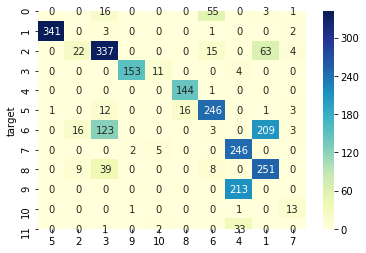

In [139]:
df_sc3 = reorder(df_sc3)
sns.heatmap(df_sc3, cmap="YlGnBu", annot=True, fmt="d")

In [140]:
df_cooc = pd.crosstab(cooc_data['target'], cooc_data[cooc_data['cooc_clusters']<20]['cooc_clusters'])
df_cooc_s = df_cooc.copy()
df_cooc_s["sum"] = df_cooc.sum(axis=1)
df_cooc_s

cooc_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,33,41,75
1,0,0,0,0,0,2,345,0,0,0,347
2,0,0,0,2,0,0,0,0,27,412,441
3,1,112,37,16,0,2,0,0,0,0,168
4,0,0,0,0,0,1,0,144,0,0,145
5,0,0,0,0,0,0,1,80,187,11,279
6,0,0,0,1,0,0,0,0,11,342,354
7,1,4,49,199,0,0,0,0,0,0,253
8,0,0,0,0,0,2,0,0,6,299,307


{1: 11, 2: 3, 3: 7, 4: 7, 5: 10, 6: 9, 7: 1, 8: 4, 9: 5, 10: 2}
[(7, 1), (10, 2), (2, 3), (8, 4), (9, 5), (3, 7), (4, 7), (6, 9), (5, 10), (1, 11)]


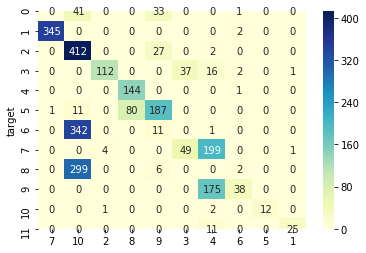

In [141]:
df_cooc = reorder(df_cooc)
sns.heatmap(df_cooc, cmap="YlGnBu", annot=True, fmt="d")

In [142]:
df_race = pd.crosstab(race_data['target'], race_data['V1'])
df_race_s = df_race.copy()
df_race_s["sum"] = df_race.sum(axis=1)
df_race_s

V1,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,sum
target,,,,,,,,,,,,,,,,,,,,,
0,25,0,36,0,2,0,0,0,0,8,...,0,1,0,0,0,0,0,0,0,75
1,87,197,19,0,1,0,2,2,0,23,...,0,0,0,0,1,0,0,0,0,347
2,278,0,109,0,14,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,441
3,2,0,0,134,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,168
4,3,0,1,0,132,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,145
5,65,0,141,0,66,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,279
6,205,0,81,0,0,0,0,0,0,67,...,0,0,0,0,0,0,0,0,0,354
7,0,0,0,36,0,105,0,0,52,0,...,0,0,0,3,0,0,0,0,0,253
8,163,0,62,0,1,0,0,0,0,79,...,0,0,1,0,0,0,0,0,0,307


{1: 2, 2: 1, 3: 5, 4: 3, 5: 4, 6: 7, 7: 1, 8: 1, 9: 7, 10: 8, 11: 9, 12: 10, 13: 9, 14: 1, 15: 2, 16: 4, 17: 1, 18: 1, 19: 2, 20: 1, 21: 0, 22: 1, 23: 2, 24: 5, 25: 4, 26: 0, 27: 4, 28: 1, 29: 1, 30: 4, 31: 9, 32: 8, 33: 1, 34: 9, 35: 1, 36: 1, 37: 5, 38: 4, 39: 9, 40: 6, 41: 9, 42: 0, 43: 9, 44: 0, 45: 8, 46: 7, 47: 1, 48: 4, 49: 10, 50: 10, 51: 9}
[(21, 0), (26, 0), (42, 0), (44, 0), (2, 1), (7, 1), (8, 1), (14, 1), (17, 1), (18, 1), (20, 1), (22, 1), (28, 1), (29, 1), (33, 1), (35, 1), (36, 1), (47, 1), (1, 2), (15, 2), (19, 2), (23, 2), (4, 3), (5, 4), (16, 4), (25, 4), (27, 4), (30, 4), (38, 4), (48, 4), (3, 5), (24, 5), (37, 5), (40, 6), (6, 7), (9, 7), (46, 7), (10, 8), (32, 8), (45, 8), (11, 9), (13, 9), (31, 9), (34, 9), (39, 9), (41, 9), (43, 9), (51, 9), (12, 10), (49, 10), (50, 10)]


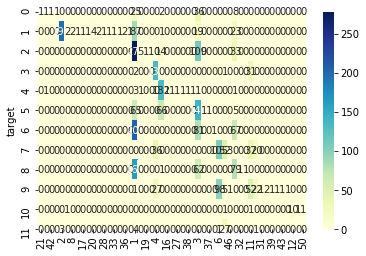

In [143]:
df_race = reorder(df_race)
sns.heatmap(df_race, cmap="YlGnBu", annot=True, fmt="d")

In [91]:
table = pd.read_csv(os.path.join(path, 'seurat-R1.csv'))
table.head(10)
sc3 = pd.read_excel('sc3_results1.xls')
sc3_r = table.merge(sc3, on="barcode")
sc3_r['target'] = sc3_r['seurat_clusters'].factorize()[0]
cooc = pd.read_csv('cooc.csv').T.reset_index()[1:]
cooc["barcode"] = cooc["index"]
cooc["cooc_clusters"] = cooc.loc[:,0]
cooc.pop("index")
cooc.pop(0)
cooc_data = table.merge(cooc, on="barcode")
cooc_data['target'] = cooc_data['seurat_clusters'].factorize()[0]
race = pd.read_csv('RaceID3.csv')
race["barcode"] = race["Unnamed: 0"]
race.pop("Unnamed: 0")
race_data = table.merge(race, on="barcode")
race_data['target'] = race_data['seurat_clusters'].factorize()[0]

In [92]:
cluster_counts(sc3_r, 'sc3_10_clusters', '3. sc3 10x')

Cluster counts for 3. sc3 10x


,count
sc3_10_clusters,
1,527.0
2,47.0
3,531.0
4,497.0
5,342.0
6,329.0
7,26.0
8,160.0
9,156.0


In [93]:
df_sc3 = pd.crosstab(sc3_r['target'], sc3_r['sc3_10_clusters'])
df_sc3_s = df_sc3.copy()
df_sc3_s["sum"] = df_sc3_s.sum(axis=1)
df_sc3_s

sc3_10_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,4,0,25,0,1,298,4,18,0,0,350
1,0,0,3,0,341,1,2,0,0,0,347
2,61,20,350,0,0,15,4,0,0,0,450
3,0,0,0,4,0,0,0,0,153,11,168
4,0,0,0,0,0,3,0,142,0,0,145
5,462,27,152,0,0,12,3,0,0,0,656
6,0,0,0,461,0,0,0,0,2,5,468
7,0,0,0,1,0,0,13,0,1,0,15
8,0,0,1,31,0,0,0,0,0,2,34


{1: 8, 2: 2, 3: 2, 4: 7, 5: 1, 6: 5, 7: 10, 8: 4, 9: 3, 10: 3}
[(5, 1), (2, 2), (3, 2), (9, 3), (10, 3), (8, 4), (6, 5), (4, 7), (1, 8), (7, 10)]


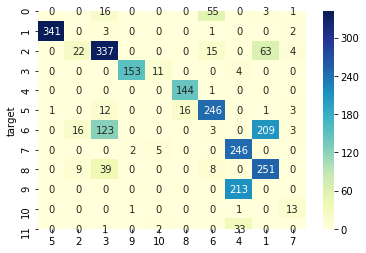

In [144]:
df_sc3 = reorder(df_sc3)
sns.heatmap(df_sc3, cmap="YlGnBu", annot=True, fmt="d")

In [145]:
df_cooc = pd.crosstab(cooc_data['target'], cooc_data[cooc_data['cooc_clusters']<20]['cooc_clusters'])
df_cooc_s = df_cooc.copy()
df_cooc_s["sum"] = df_cooc.sum(axis=1)
df_cooc_s

cooc_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,33,41,75
1,0,0,0,0,0,2,345,0,0,0,347
2,0,0,0,2,0,0,0,0,27,412,441
3,1,112,37,16,0,2,0,0,0,0,168
4,0,0,0,0,0,1,0,144,0,0,145
5,0,0,0,0,0,0,1,80,187,11,279
6,0,0,0,1,0,0,0,0,11,342,354
7,1,4,49,199,0,0,0,0,0,0,253
8,0,0,0,0,0,2,0,0,6,299,307


{1: 11, 2: 3, 3: 7, 4: 7, 5: 10, 6: 9, 7: 1, 8: 4, 9: 5, 10: 2}
[(7, 1), (10, 2), (2, 3), (8, 4), (9, 5), (3, 7), (4, 7), (6, 9), (5, 10), (1, 11)]


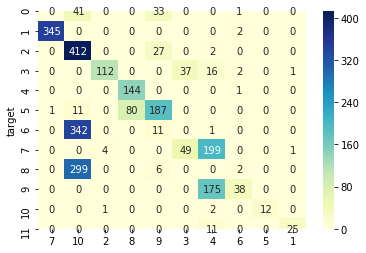

In [146]:
df_cooc = reorder(df_cooc)
sns.heatmap(df_cooc, cmap="YlGnBu", annot=True, fmt="d")

In [147]:
table = pd.read_csv(os.path.join(path, 'seurat-R8.csv'))
table.head(10)
sc3 = pd.read_excel('sc3_results1.xls')
sc3_r = table.merge(sc3, on="barcode")
sc3_r['target'] = sc3_r['seurat_clusters'].factorize()[0]
cooc = pd.read_csv('cooc.csv').T.reset_index()[1:]
cooc["barcode"] = cooc["index"]
cooc["cooc_clusters"] = cooc.loc[:,0]
cooc.pop("index")
cooc.pop(0)
cooc_data = table.merge(cooc, on="barcode")
cooc_data['target'] = cooc_data['seurat_clusters'].factorize()[0]
race = pd.read_csv('RaceID3.csv')
race["barcode"] = race["Unnamed: 0"]
race.pop("Unnamed: 0")
race_data = table.merge(race, on="barcode")
race_data['target'] = race_data['seurat_clusters'].factorize()[0]

In [148]:
df_cooc = pd.crosstab(cooc_data['target'], cooc_data[cooc_data['cooc_clusters']<20]['cooc_clusters'])
df_cooc_s = df_cooc.copy()
df_cooc_s["sum"] = df_cooc.sum(axis=1)
df_cooc_s

cooc_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,0,0,0,3,0,0,0,0,51,591,645
1,0,0,0,0,0,2,345,0,0,0,347
2,1,112,41,16,0,2,0,0,0,0,172
3,0,0,0,0,0,1,0,144,1,0,146
4,0,0,0,0,0,1,1,80,203,42,327
5,0,0,0,0,0,2,0,0,9,472,483
6,2,4,45,380,0,38,0,0,0,0,469
7,0,1,0,2,12,0,0,0,0,0,15
8,24,0,0,5,0,0,0,0,0,0,29


{1: 8, 2: 2, 3: 6, 4: 6, 5: 7, 6: 6, 7: 1, 8: 3, 9: 4, 10: 0}
[(10, 0), (7, 1), (2, 2), (8, 3), (9, 4), (3, 6), (4, 6), (6, 6), (5, 7), (1, 8)]


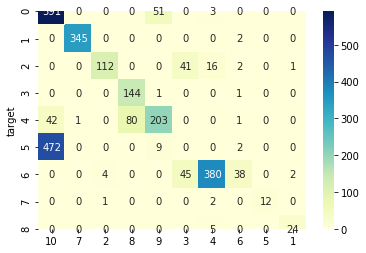

In [149]:
df_cooc = reorder(df_cooc)
sns.heatmap(df_cooc, cmap="YlGnBu", annot=True, fmt="d")

In [150]:
df_sc3 = pd.crosstab(sc3_r['target'], sc3_r['sc3_10_clusters'])
df_sc3_s = df_sc3.copy()
df_sc3_s["sum"] = df_sc3_s.sum(axis=1)
df_sc3_s

sc3_10_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,136,28,440,0,0,35,6,0,0,0,645
1,0,0,3,0,341,1,2,0,0,0,347
2,0,0,0,6,0,0,0,0,154,12,172
3,0,0,0,0,0,4,0,142,0,0,146
4,4,0,15,0,1,285,4,18,0,0,327
5,387,19,72,0,0,4,1,0,0,0,483
6,0,0,0,464,0,0,0,0,1,4,469
7,0,0,0,1,0,0,13,0,1,0,15
8,0,0,1,26,0,0,0,0,0,2,29


{1: 5, 2: 0, 3: 0, 4: 6, 5: 1, 6: 4, 7: 7, 8: 3, 9: 2, 10: 2}
[(2, 0), (3, 0), (5, 1), (9, 2), (10, 2), (8, 3), (6, 4), (1, 5), (4, 6), (7, 7)]


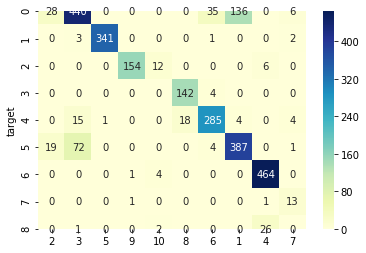

In [151]:
df_sc3 = reorder(df_sc3)
sns.heatmap(df_sc3, cmap="YlGnBu", annot=True, fmt="d")

In [152]:
table = pd.read_csv(os.path.join(path, 'seurat-R-stan.csv'))
table.head(10)
sc3 = pd.read_excel('sc3_results1.xls')
sc3_r = table.merge(sc3, on="barcode")
sc3_r['target'] = sc3_r['seurat_clusters'].factorize()[0]
cooc = pd.read_csv('cooc.csv').T.reset_index()[1:]
cooc["barcode"] = cooc["index"]
cooc["cooc_clusters"] = cooc.loc[:,0]
cooc.pop("index")
cooc.pop(0)
cooc_data = table.merge(cooc, on="barcode")
cooc_data['target'] = cooc_data['seurat_clusters'].factorize()[0]
race = pd.read_csv('RaceID3.csv')
race["barcode"] = race["Unnamed: 0"]
race.pop("Unnamed: 0")
race_data = table.merge(race, on="barcode")
race_data['target'] = race_data['seurat_clusters'].factorize()[0]

In [153]:
df_cooc = pd.crosstab(cooc_data['target'], cooc_data[cooc_data['cooc_clusters']<20]['cooc_clusters'])
df_cooc_s = df_cooc.copy()
df_cooc_s["sum"] = df_cooc.sum(axis=1)
df_cooc_s

cooc_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,0,0,0,0,0,1,1,80,219,49,350
1,0,0,0,0,0,2,345,0,0,0,347
2,0,0,0,2,0,0,0,0,30,480,512
3,1,112,37,16,0,2,0,0,0,0,168
4,0,0,0,0,0,1,0,144,0,0,145
5,0,0,0,1,0,2,0,0,15,576,594
6,1,4,49,374,0,38,0,0,0,0,466
7,0,1,0,2,12,0,0,0,0,0,15
8,25,0,0,11,0,0,0,0,0,0,36


{1: 8, 2: 3, 3: 6, 4: 6, 5: 7, 6: 6, 7: 1, 8: 4, 9: 0, 10: 5}
[(9, 0), (7, 1), (2, 3), (8, 4), (10, 5), (3, 6), (4, 6), (6, 6), (5, 7), (1, 8)]


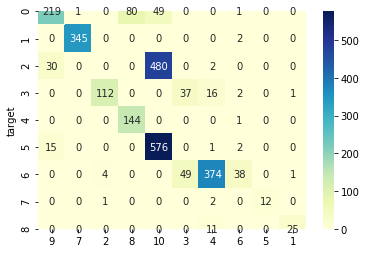

In [154]:
df_cooc = reorder(df_cooc)
sns.heatmap(df_cooc, cmap="YlGnBu", annot=True, fmt="d")

In [110]:
df_sc3 = pd.crosstab(sc3_r['target'], sc3_r['sc3_10_clusters'])
df_sc3_s = df_sc3.copy()
df_sc3_s["sum"] = df_sc3_s.sum(axis=1)
df_sc3_s

sc3_10_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,4,0,25,0,1,300,4,16,0,0,350
1,0,0,3,0,341,1,2,0,0,0,347
2,78,24,387,0,0,18,5,0,0,0,512
3,0,0,0,4,0,0,0,0,153,11,168
4,0,0,0,0,0,1,0,144,0,0,145
5,445,23,115,0,0,9,2,0,0,0,594
6,0,0,0,459,0,0,0,0,2,5,466
7,0,0,0,1,0,0,13,0,1,0,15
8,0,0,1,33,0,0,0,0,0,2,36


{1: 5, 2: 2, 3: 2, 4: 6, 5: 1, 6: 0, 7: 7, 8: 4, 9: 3, 10: 3}


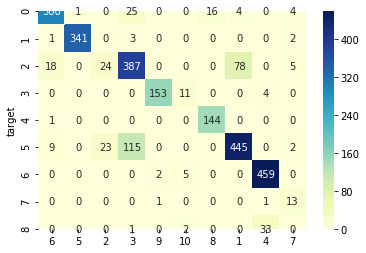

In [111]:
df_sc3 = reorder(df_sc3)
sns.heatmap(df_sc3, cmap="YlGnBu", annot=True, fmt="d")